<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/TimeSeries/QuasarLightcurvesLSTM_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2017-2021 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Quasar classification by LSTM


Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this notebook, we are going to use LSTMs to classify between stars and quasars, using only information about the flux at different point in time.

The idea is to distinguish between stars, and quasars, based on how their fluxes change with time.

We are using real light curve data from the SDSS survey, and using an catalog of known quasars for our training set. 

### Learning objectives:
In this notebook, we will learn how to:

  - Learn how to handle time-series data of different lenghts
  - Use Keras for building an LSTM


### Instructions for enabling GPU access

By default, notebooks are started without acceleration. To make sure that the runtime is configured for using GPUs, go to `Runtime > Change runtime type`, and select GPU in `Hardware Accelerator`.



### Installs and Imports


In [1]:
%pylab inline
import tensorflow as tf
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


### Checking for GPU access


In [2]:
#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Retrieving data

In this first section, we retrieve a dataset of lightcurves as generated by this [script](https://github.com/McWilliamsCenter/CMUCosmoML/tree/master/applications/quasar_classification) by running an SQL query on the SDSS servers.

In [3]:
# Google Cloud Storage bucket for Estimator logs and storing
# the training dataset.
bucket = 'ahw2019' # Bucket setup for this AHW2019 tutorial
print('Using bucket: {}'.format(bucket))

Using bucket: ahw2019


In [4]:
!gsutil -m cp gs://{bucket}/quasar/ligthcurve_data.fits.gz .

Copying gs://ahw2019/quasar/ligthcurve_data.fits.gz...
| [1/1 files][137.9 MiB/137.9 MiB] 100% Done                                    
Operation completed over 1 objects/137.9 MiB.                                    


This will download locally the training set. We can now load it to build our input pipeline.


Below we create functions that can build input pipelines:

In [5]:
# Loading dataset
data_table = Table.read('ligthcurve_data.fits.gz')

# Splitting training and testing data
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:45000]
randomized_inds_test  = randomize_inds[45000:]

`data_table` contains all of the data available to us from the database:

In [6]:
data_table

coadd_objid,objid,ra,dec,run,mjd_u,mjd_g,mjd_r,mjd_i,mjd_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,distance,coadd_ra,coadd_dec,coadd_run,coadd_field,coadd_psfMag_u,coadd_psfMag_g,coadd_psfMag_r,coadd_psfMag_i,coadd_psfMag_z,coadd_psfmagerr_u,coadd_psfmagerr_g,coadd_psfmagerr_r,coadd_psfmagerr_i,coadd_psfmagerr_z,coadd_extinction_u,coadd_extinction_g,coadd_extinction_r,coadd_extinction_i,coadd_extinction_z,coadd_flags,coadd_label,mjd,mjd_std,psfMag_u_std,psfMag_g_std,psfMag_r_std,psfMag_i_std,psfMag_z_std,obs_len,obs_id,"time_series [90,12]"
int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float32
8647474690316960812,8658177821831397821,320.003122281485,-1.07208310065828,1755,51819.2440009,51819.2456596,51819.2423423,51819.2431716,51819.2448302,22.7657548,20.1503938,19.2113898,18.8344162,18.702744889999998,0.4908674,0.02907639,0.0189517,0.02152076,0.03939919,0.2619852,0.1927662,0.1398102,0.1060138,0.07516511,-0.4852178495678217,320.003102986969,-1.07208796797388,106,134,22.2738894,20.152764,19.199939,18.8662883,18.64334057,0.08853411,0.007023782,0.003271084,0.00347838,0.00885856,0.2619306,0.192726,0.139781,0.1059917,0.07514943,34628173824,0,51819.24400091999,17.273081333639997,0.9568798133439743,-0.04444016936817476,0.09539415907273395,-0.4219517187729731,0.41591472476755714,45,0,0.0 .. 0.0
8647474690316960856,8658174750931288473,320.012546522809,-1.09549028382869,1040,51465.1636677,51465.1653263,51465.1620092,51465.1628384,51465.164497,21.2396299,19.0752391,18.0279199,17.6526676,17.44921018,0.1458025,0.01550561,0.01457854,0.01490439,0.02383653,0.2599801,0.1912909,0.1387401,0.1052024,0.07458982,0.39737010573841425,320.012566786967,-1.09548782258257,106,134,21.4203582,19.0535873,18.0199604,17.6586931,17.43566117,0.04176774,0.003089944,0.001545239,0.001537709,0.003566296,0.2599418,0.1912627,0.1387196,0.1051869,0.07457883,34628173824,0,51465.16366772,17.155054555906666,-0.25896877503101373,0.13607993624460032,0.05626088164145182,-0.10898400282421541,0.09423424164751563,55,1,0.0 .. 0.0
8647474690316960889,8658174750931354201,320.025640161897,-1.11285730470859,1040,51465.1640823,51465.1657409,51465.1624239,51465.163253,51465.1649116,21.2236257,20.3976683,19.989207999999998,19.944650099999997,19.8820272,0.1434325,0.03295132,0.02841236,0.03642111,0.1326928,0.2590843,0.1906317,0.138262,0.1048399,0.0743328,-0.7360403785711456,320.025628306671,-1.11285451560308,106,134,21.228490999999998,20.4042816,19.9967621,19.8690984,19.78445018,0.03554705,0.008720344,0.006081987,0.007859246,0.02386913,0.259039,0.1905984,0.1382379,0.1048216,0.07431982,301989904,0,51465.16408234001,17.155054694113336,0.05893902026559874,-0.07632614306418282,-0.11762793133901978,0.878806652716287,0.6837007800356916,50,2,0.0 .. 0.0
8647474690316960891,8658174750931354091,320.026494659486,-1.18352218437282,1040,51465.1640823,51465.1657409,51465.1624239,51465.163253,51465.1649116,22.6319696,20.1193344,18.7521402,18.070641199999997,17.718987509999998,0.4835441,0.02676469,0.0148213,0.01419389,0.02575127,0.2501604,0.1840656,0.1334998,0.1012288,0.07177249,2.068172915669189,320.02648345193,-1.18357930525637,106,134,22.721603899999998,20.096241699999997,18.7607846,18.0908972,17.69577595,0.1315791,0.006711706,0.002483103,0.002071123,0.004374565,0.2500961,0.1840183,0.1334654,0.1012028,0.07175405,34628174336,0,51465.16408234001,17.155054694113336,-0.09429802163348133,0.14690798637272534,-0.1298488841025403,-0.28129630238430064,0.162018185364612,64,3,0.0 .. 0.0
8647474690316960900,

In particular, it has a fixed size `time_series` field and an `obs_len` field. This `obs_len` tells us how many points we actually have in our timeseries.

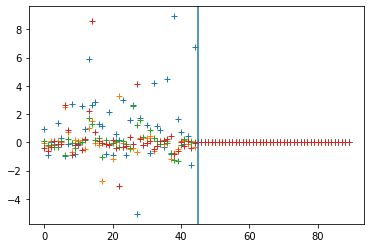

In [7]:
# Let's plot the observation of the flux of some quasars/stars in different
# filters:
plot(data_table['time_series'][0][:,1], '+')
plot(data_table['time_series'][0][:,2], '+')
plot(data_table['time_series'][0][:,3], '+')
plot(data_table['time_series'][0][:,4], '+')
axvline(data_table['obs_len'][0])

Let's have a look at a different entry:


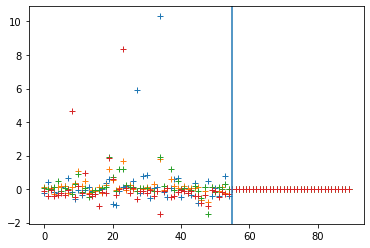

In [8]:
plot(data_table['time_series'][1][:,1], '+')
plot(data_table['time_series'][1][:,2], '+')
plot(data_table['time_series'][1][:,3], '+')
plot(data_table['time_series'][1][:,4], '+')
axvline(data_table['obs_len'][1])

They have different lengths, how do we provide this information to the RNN? 

We can use a `masking` mechanism. We always send arrays of the same size, but some timesteps, if they are not actually observed are set to a specific value, i.e. -99 and the network will skip these missing steps.

Let's create a pre-processing function that can format our data on this principle:

In [9]:
def mapping_function(x):
    def extract_batch(inds):
        inds = randomized_inds_train[inds]
        ts = clip(data_table['time_series'][inds].astype('float32'),-10,10) 
        length = clip(data_table['obs_len'][inds],0,89).astype('int32')
        ts[length:,:] = -99. # Any points in the light curve after obs_len is set to -99
        return data_table['coadd_label'][inds].astype('float32'), ts
    a,b =tf.py_function( extract_batch, [x], [tf.float32, tf.float32])
    a.set_shape([])
    b.set_shape([90,12])
    return a,b

In [10]:
# And we can apply this pre-processing function on our data to build a tf.data.Dataset
dataset = tf.data.Dataset.range(len(randomized_inds_train))
dataset = dataset.map(mapping_function)

In [11]:
dataset

<MapDataset shapes: ((), (90, 12)), types: (tf.float32, tf.float32)>

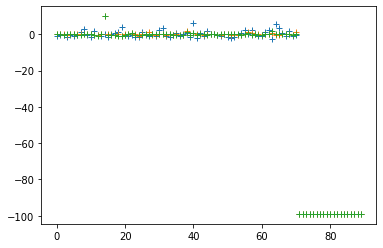

In [12]:
# Let's grab an example
for batch in dataset.take(1):
  plot(batch[1][:,1], '+')
  plot(batch[1][:,2], '+')
  plot(batch[1][:,3], '+')

Ok great, now we are going to create functions that can produce datasets for various training and testing scenarios.

In the functions below, what changes is which dataset we are using (training or testing), and whether or not entries are shuffled.

In [13]:
# Define input function for training 
def input_fn_train():
  def mapping_function(x):
      def extract_batch(inds):
          inds = randomized_inds_train[inds]
          ts = clip(data_table['time_series'][inds].astype('float32'),-10,10) 
          length = clip(data_table['obs_len'][inds],0,89).astype('int32')
          ts[length:,:] = -99. 
          return data_table['coadd_label'][inds].astype('float32'), ts
      a,b =tf.py_function( extract_batch, [x], [tf.float32, tf.float32])
      a.set_shape([]) # This is the label
      b.set_shape([90,12]) # This is the input light curve
      return b,a

  dataset = tf.data.Dataset.range(len(randomized_inds_train))
  dataset = dataset.map(mapping_function)
  dataset = dataset.cache()
  dataset = dataset.repeat().shuffle(20000).batch(256)
  return  dataset

# Define input function for testing on the training set
def input_fn_train_test():
  def mapping_function(x):
      def extract_batch(inds):
          inds = randomized_inds_train[inds]
          ts = clip(data_table['time_series'][inds].astype('float32'),-10,10) 
          length = clip(data_table['obs_len'][inds],0,89).astype('int32')
          ts[length:,:] = -99. 
          return data_table['coadd_label'][inds].astype('float32'), ts
      a,b =tf.py_function( extract_batch, [x], [tf.float32, tf.float32])
      a.set_shape([]) # This is the label
      b.set_shape([90,12]) # This is the input light curve
      return b,a

  dataset = tf.data.Dataset.range(len(randomized_inds_train))
  dataset = dataset.map(mapping_function)
  dataset = dataset.batch(256)
  return  dataset

# Define input function for testing on the testing set
def input_fn_test():
  def mapping_function(x):
      def extract_batch(inds):
          inds = randomized_inds_test[inds]
          ts = clip(data_table['time_series'][inds].astype('float32'),-10,10) 
          length = clip(data_table['obs_len'][inds],0,89).astype('int32')
          ts[length:,:] = -99. 
          return data_table['coadd_label'][inds].astype('float32'), ts
      a,b =tf.py_function( extract_batch, [x], [tf.float32, tf.float32])
      a.set_shape([]) # This is the label
      b.set_shape([90,12]) # This is the input light curve
      return b,a

  dataset = tf.data.Dataset.range(len(randomized_inds_test))
  dataset = dataset.map(mapping_function)
  dataset = dataset.batch(256)
  return  dataset

## Building the Neural Network

Now that we have the tools to load the data, the next step is to build the LSTM model. We will start with the simplest model possible, an LSTM layer that will process the time-series, followed by a Dense layer that will produce a probability of a timeseries to be a quasar:

In [14]:
tfkl = tf.keras.layers

model = tf.keras.Sequential([
  tfkl.InputLayer([90,12]),
  tfkl.Masking(mask_value=-99.), # This is to tell Keras to skip the missing time steps
  tfkl.LSTM(128),
  tfkl.Dense(128, activation='relu'),
  tfkl.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 90, 12)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88,833
Trainable params: 88,833
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy') # This is a classification task, so
                                          # binary cross-entropy is justified

In [17]:
# Let's build the input dataset
dataset_training = input_fn_train()

In [18]:
# And fit the model
model.fit(dataset_training, 
          steps_per_epoch=45000//256,
          epochs=5)

Epoch 1/5
175/175 [==============================] - 49s 146ms/step - loss: 0.1491
Epoch 2/5
175/175 [==============================] - 3s 15ms/step - loss: 0.0855
Epoch 3/5
175/175 [==============================] - 2s 14ms/step - loss: 0.0704
Epoch 4/5
175/175 [==============================] - 2s 14ms/step - loss: 0.0775
Epoch 5/5
175/175 [==============================] - 2s 14ms/step - loss: 0.0664


### Applying the neural network on the testing set

In [19]:
# Evaluating performance on testing set
dataset_testing = input_fn_test()
test_prob = np.concatenate([model(batch[0]) for batch in dataset_testing])

# Concatenating the predicted probabilities
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob.squeeze()

In [20]:
# Evaluating performance on training set
dataset_training = input_fn_train_test()
train_prob = np.concatenate([model(batch[0]) for batch in dataset_training])

# Concatenating the predicted probabilities
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob.squeeze()

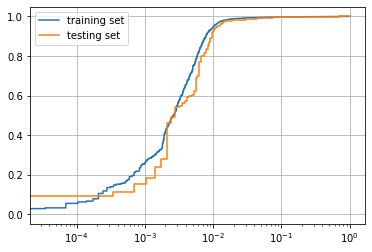

In [21]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(table_train['coadd_label'], table_train['p'])
fpr2, tpr2, thr2 = roc_curve(table_test['coadd_label'],  table_test['p'])

plot(fpr1, tpr1,label='training set')
plot(fpr2, tpr2,label='testing set')
grid('on')
xscale('log')
legend()

In [ ]:
from sklearn.metrics import roc_auc_score

print("Training Set ROC AUC score:", roc_auc_score(table_train['coadd_label'], table_train['p']))
print("Test Set ROC AUC score:", roc_auc_score(table_test['coadd_label'], table_test['p']))

Training Set ROC AUC score: 0.9945351027615053
Test Set ROC AUC score: 0.9943949468525998


And here  we go! A near perfect Quasar detector :-)

## Going Further

This is pretty much all you need to know to implement a Recurrent Neural Network. You can find the reference guide for the TensorFlow Keras guide [here](https://www.tensorflow.org/guide/keras/rnn).

To go further in this tutorial, you can do the following things:

  - LSTMs are **notorious for overfitting** data very easily, to prevent this, you can add a `dropout` value to the `LSTM` layer.
  - You can replace the `LSTM` layer by a different RNN type, for instance [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
  - You can add a second LSTM layer, like so:
```
...
  tfkl.LSTM(128, return_sequences=True),
  tfkl.LSTM(128),
...
```

